In [118]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from dataclasses import dataclass
import typing as T
import datetime

In [3]:
from_date = widgets.DatePicker()
to_date = widgets.DatePicker()
print('From date:')
display(from_date)
print('To date:')
display(to_date)

From date:


DatePicker(value=None)

To date:


DatePicker(value=None)

In [4]:
url = f"https://api.energidataservice.dk/dataset/Elspotprices/download?format=XL&offset=0&start={from_date.value}T00:00&end={to_date.value}T00:00&filter=%7B%22PriceArea%22:%22DK2%22%7D&sort=HourDK%20DESC&timezone=dk"
df = pd.read_excel(url)
df['dt'] = df.HourDK.dt.date
df['h'] = df.HourDK.dt.hour
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2022-10-02 21:00:00,2022-10-02 23:00:00,DK2,1122.260010,150.919998,2022-10-02,23
1,2022-10-02 20:00:00,2022-10-02 22:00:00,DK2,1209.859985,162.699997,2022-10-02,22
2,2022-10-02 19:00:00,2022-10-02 21:00:00,DK2,1713.800049,230.470001,2022-10-02,21
3,2022-10-02 18:00:00,2022-10-02 20:00:00,DK2,2156.330078,289.980011,2022-10-02,20
4,2022-10-02 17:00:00,2022-10-02 19:00:00,DK2,2317.989990,311.720001,2022-10-02,19


In [5]:
df.HourDK.max()

Timestamp('2022-10-02 23:00:00')

In [6]:
def spot_heatmap(df, annot=True):
    dates = sorted(df.dt.unique())
    df_plot = pd.DataFrame(index=sorted(df.h.unique()))
    for date in dates:
        dt_col = date.isoformat().replace('-', '_')
        df_sub = df[df.dt == date].set_index('h').SpotPriceDKK.to_frame(dt_col)
        df_sub[dt_col] = df_sub[dt_col] / 1000.0
        df_plot = df_plot.join(df_sub)
    sns.heatmap(df_plot, annot=annot, cmap='RdYlGn_r', fmt='.3g')
    plt.show()

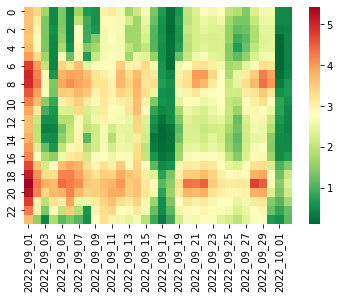

In [7]:
spot_heatmap(df, annot=False)

In [8]:
df.to_csv('../snap2.csv', index=False)

In [21]:
df

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,2022-10-02 21:00:00,2022-10-02 23:00:00,DK2,1122.260010,150.919998,2022-10-02,23
1,2022-10-02 20:00:00,2022-10-02 22:00:00,DK2,1209.859985,162.699997,2022-10-02,22
2,2022-10-02 19:00:00,2022-10-02 21:00:00,DK2,1713.800049,230.470001,2022-10-02,21
3,2022-10-02 18:00:00,2022-10-02 20:00:00,DK2,2156.330078,289.980011,2022-10-02,20
4,2022-10-02 17:00:00,2022-10-02 19:00:00,DK2,2317.989990,311.720001,2022-10-02,19
...,...,...,...,...,...,...,...
763,2022-09-01 02:00:00,2022-09-01 04:00:00,DK2,3682.840088,495.179993,2022-09-01,4
764,2022-09-01 01:00:00,2022-09-01 03:00:00,DK2,3570.090088,480.019989,2022-09-01,3
765,2022-09-01 00:00:00,2022-09-01 02:00:00,DK2,3617.090088,486.339996,2022-09-01,2
766,2022-08-31 23:00:00,2022-09-01 01:00:00,DK2,3602.360107,484.359985,2022-09-01,1


In [35]:
df_daily = df.groupby(['dt', 'PriceArea']).agg(
    {'SpotPriceDKK': [('MinPriceDKK', 'min'), ('MaxPriceDKK', 'max')]}).SpotPriceDKK.reset_index()
df_daily['diff'] = df_daily.MaxPriceDKK - df_daily.MinPriceDKK
df_daily.mean()

/var/folders/6c/gc7czb2n3_357wttfrdbgzrr0000gn/T/ipykernel_22351/472351948.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_daily.mean()


MinPriceDKK    1323.462195
MaxPriceDKK    3594.232506
diff           2270.770310
dtype: float64

In [132]:
@dataclass
class MarketState:
    date0: datetime.date
    date1: datetime.date
    hours0: np.ndarray
    hours1: np.ndarray        
    rates0: np.ndarray
    rates1: np.ndarray

def market_states(df, repeat=False):
    hs = np.arange(24)
    seq = list(df.sort_values(by='HourDK').groupby('dt'))
    window_size = 2
    n = len(seq) - window_size + 1
    for epoch in range(repeat):
        for i in range(n):
            pair = seq[i: i + window_size]
            if len(pair[0][1]) != 24 or len(pair[1][1]) != 24: continue
            s = MarketState(
                date0=pair[0][0],
                date1=pair[1][0],
                hours0=pair[0][1].h.values,
                hours1=pair[1][1].h.values,
                rates0=pair[0][1].SpotPriceDKK.values,
                rates1=pair[1][1].SpotPriceDKK.values,
            )
            yield s


In [134]:
for i, state in enumerate(market_states(df, repeat=True)):
    print(i, state.date0)
    if i > 35: break

0 2022-09-01
1 2022-09-02
2 2022-09-03
3 2022-09-04
4 2022-09-05
5 2022-09-06
6 2022-09-07
7 2022-09-08
8 2022-09-09
9 2022-09-10
10 2022-09-11
11 2022-09-12
12 2022-09-13
13 2022-09-14
14 2022-09-15
15 2022-09-16
16 2022-09-17
17 2022-09-18
18 2022-09-19
19 2022-09-20
20 2022-09-21
21 2022-09-22
22 2022-09-23
23 2022-09-24
24 2022-09-25
25 2022-09-26
26 2022-09-27
27 2022-09-28
28 2022-09-29
29 2022-09-30
30 2022-10-01
31 2022-09-01
32 2022-09-02
33 2022-09-03
34 2022-09-04
35 2022-09-05
36 2022-09-06


In [88]:
it = iter(range(3))
print(bool(it))
try:
    while True: next(it)
except:
    pass
print(bool(it))

True
True
